# Using netMHC predictions

In [1]:
import numpy as np
import pandas as pd
from scipy.stats import entropy
import sklearn.decomposition
import sklearn.manifold
import seaborn as sns
import matplotlib.pyplot as plt
% matplotlib inline

from lib import *

In [4]:
pd.read_csv?

In [22]:
df = pd.read_csv('/home/amayer/data/proteomes/uniprot-PlasmodiumFalciparum-up000001450-netmhc.csv', sep='\t', skiprows=1)
df.head()

,Pos,Peptide,ID,nM,Rank,Core,H_Avg_Ranks,N_binders
0,0,MAEEYSWDS,sp_Q8I2J4_PROF_,18695.6,26.0,MAEEYSWDS,26.0,0
1,1,AEEYSWDSY,sp_Q8I2J4_PROF_,35496.2,65.0,AEEYSWDSY,65.0,0
2,2,EEYSWDSYL,sp_Q8I2J4_PROF_,27551.2,41.0,EEYSWDSYL,41.0,0
3,3,EYSWDSYLN,sp_Q8I2J4_PROF_,42123.9,90.0,EYSWDSYLN,90.0,0
4,4,YSWDSYLND,sp_Q8I2J4_PROF_,22761.2,32.0,YSWDSYLND,32.0,0


In [23]:
df_weakbinders = df[df['nM']<50]

In [16]:
df = counter_to_df(count_kmers_proteome(human, 1), norm=True)
df = df.set_index('seq')
humanaaprobdict = np.log10(df['freq']).to_dict()

df1 = counter_to_df(count_kmers_proteome(human, 2), norm=False)
strcolumn_to_charcolumns(df1, 'seq')
count = df1.pivot(columns='aa1', index='aa2')['count']
count /= np.sum(count, axis=0)
count[count.isna()] = 1e-10
humandoubletprobdict = np.log10(count).to_dict()

df2 = counter_to_df(count_kmers_proteome(human, 3), norm=False)
df2['aa12'] = [s[:2] for s in df2['seq']]
df2['aa3'] = [s[2] for s in df2['seq']]
count = df2.pivot(columns='aa12', index='aa3')['count']
count /= np.sum(count, axis=0)
count[count.isna()] = 1e-10
humantripletprobdict = np.log10(count).to_dict()

Malaria
1261
11207814 167749 74 1345


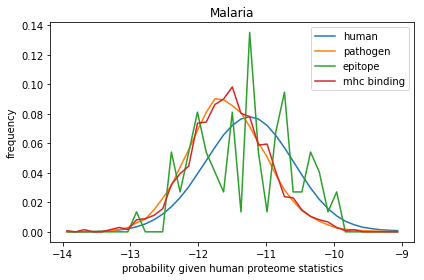

In [25]:
dfproteomes = pd.read_csv('../data/proteomes.csv', sep=',')
pathogenproteomes = dfproteomes[dfproteomes['type'].isin(['parasite'])]

dfepitopes = pd.read_csv(datadir+'allhuman-iedb-epitopes.csv', header=1, usecols=(2, 9, 14))
dfepitopes = dfepitopes.fillna('')
dfepitopes['length'] = [len(d) for d in dfepitopes['Description']]

loglikelihood = lambda seq, k: loglikelihood_triplet(seq, humanaaprobdict, humandoubletprobdict, humantripletprobdict, k=k)
likelihoodname = 'triplet'
#loglikelihood = lambda seq, k: loglikelihood_independent(seq, humanaaprobdict, k=k)
#likelihoodname = 'independent'

#for k in [9, 15]:
for k in [9]:
    phuman = np.array([loglikelihood(seq[i:i+k], k) for h, seq in fasta_iter(human) for i in range(len(seq)-k+1) ])

    for idx, row in pathogenproteomes.iterrows():
        name = row['shortname']
        iedbname = row['iedbname']
        path = datadir + row['path']
        print(name)

        dfepitope = dfepitopes[dfepitopes['Parent Organism'].str.contains(iedbname)]
        print(len(dfepitope))

        epi = list(dfepitope[dfepitope['length']==k]['Description'])
        #pepitope = np.array([loglikelihood(seq, k) for seq in epi])
        #epi = list(dfepitope['Description'])
        pepitope = np.array([loglikelihood(seq[i:i+k], k) for seq in epi for i in range(len(seq)-k+1)])
        pepitope = pepitope[~np.isnan(pepitope)]
        
        ppredepitope = np.array([loglikelihood(seq, k) for seq in df_weakbinders['Peptide']])

        ppathogen = np.array([loglikelihood(seq[i:i+k], k) for h, seq in fasta_iter(path) for i in range(len(seq)-k+1) ])
        ppathogen = ppathogen[~np.isnan(ppathogen)]

        print(len(phuman), len(ppathogen), len(pepitope), len(ppredepitope))

        if len(pepitope) > 2:
            fig, ax = plt.subplots()
            plot_histograms([phuman, ppathogen, pepitope, ppredepitope], ['human', 'pathogen', 'epitope', 'mhc binding'], xmin=-14, xmax=-9, ax=ax)
            ax.set_ylabel('frequency')
            ax.set_xlabel('probability given human proteome statistics')
            plt.title(name)
            fig.tight_layout()
            #fig.savefig('plots/likelihoodprofile-%s-%s-k%i.png' % (name, likelihoodname, k), dpi=300)